# Regime filter optimiser

- This is a notebook to mostly demostrate how to integrate `scikit-optimize` to your workflow
- Optimise the regime filter by running a search of different combinations 
    - Find the best ADX regime filter parameters for given trading pairs
    - The definition of best is somewhat arbirary here: how many bull market days the regime filter matches correct
    - Use a very simple regime filter function - might not be suitable for real use
- We use `scikit-optimize` Python library and its [Optimizer](https://scikit-optimize.github.io/stable/modules/generated/skopt.Optimizer.html)
    - Bayes search is much faster than brute force grid search
    - We define ADX regime filter parameter search space as `scikit-optimize` search space    
    - This is also called "hyperparameter search" as we can have any number of dimensions for our parameters
- How `Optimizer` works is explained in detail later
- We do the search [using multiple parallel workers](https://scikit-optimize.github.io/dev/auto_examples/parallel-optimization.html)
    - Some extra setup is needed with data logistics for multiple Python processes
- This is a simplified optimiser
    - There are no separate training and evaluation datasets
    - The result is likely to be overfit for the given training data

# Set up

Set up Trading Strategy data client.


In [1]:
import typing

from tradingstrategy.client import Client
from tradeexecutor.utils.notebook import setup_charting_and_output, OutputMode

client = Client.create_jupyter_client()

# Set up drawing charts in interactive vector output mode.
# This is slower. See the alternative commented option below.
# setup_charting_and_output(OutputMode.interactive)

# Set up rendering static PNG images.
# This is much faster but disables zoom on any chart.
setup_charting_and_output(OutputMode.static, image_format="png", width=1500, height=1000)


Started Trading Strategy in Jupyter notebook environment, configuration is stored in /Users/moo/.tradingstrategy


# Parameters

- Strategy parameters define the fixed and grid searched parameters

In [2]:
from tradingstrategy.chain import ChainId
import datetime

from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.parameters import StrategyParameters


class Parameters:

    id = "regime-filter-playground" # Used in cache paths

    candle_time_bucket = TimeBucket.m15  
    allocation = 0.98

    # See comment below
    # adx_length = [i for i in range(7, 60)]
    # adx_filter_threshold = [i for i in range(10, 40)]

    #
    # Backtesting only
    #
    backtest_start = datetime.datetime(2020, 1, 1)
    backtest_end = datetime.datetime(2024, 5, 20)

parameters = StrategyParameters.from_class(Parameters)  # Convert to AttributedDict to easier typing with dot notation


# Search space

Because we use scikit we need to define search space using its primitives.
We use only discrete integers as a search space, because we cache the calculation results on disk
and we do not want to fill the cache with arbitrary floating point values.

- [How to define search space in scikit-optimize](https://scikit-optimize.github.io/stable/auto_examples/hyperparameter-optimization.html)

In [3]:
from skopt import space

# Because we use scikit-optimizer we need to define
# searchable parameters using its search space definition.
# The values of these are later passed as argument dict to the optimizer function.
search_space = [
    space.Integer(1, 60, name="adx_length"),
    space.Integer(1, 60, name="adx_filter_threshold")
]


# Trading pairs and market data

- Set up our trading pairs
- Load historical market data for backtesting
- We use Binance CEX data so we have longer history to backtest

In [4]:
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.client import Client
from tradeexecutor.strategy.execution_context import ExecutionContext, notebook_execution_context
from tradeexecutor.utils.binance import create_binance_universe
from tradeexecutor.strategy.universe_model import UniverseOptions

trading_pairs = [
    (ChainId.centralised_exchange, "binance", "BTC", "USDT"),
    (ChainId.centralised_exchange, "binance", "ETH", "USDT"),
    (ChainId.centralised_exchange, "binance", "MATIC", "USDT"),
    (ChainId.centralised_exchange, "binance", "LINK", "USDT"),
    (ChainId.centralised_exchange, "binance", "PEPE", "USDT"),
    (ChainId.centralised_exchange, "binance", "BNB", "USDT"),
]


def create_trading_universe(
    timestamp: datetime.datetime,
    client: Client,
    execution_context: ExecutionContext,
    universe_options: UniverseOptions,
) -> TradingStrategyUniverse:
    strategy_universe = create_binance_universe(
        [f"{p[2]}{p[3]}" for p in trading_pairs],
        candle_time_bucket=Parameters.candle_time_bucket,
        start_at=universe_options.start_at,
        end_at=universe_options.end_at,
        forward_fill=True,
    )
    return strategy_universe


strategy_universe = create_trading_universe(
    None,
    client,
    notebook_execution_context,
    UniverseOptions.from_strategy_parameters_class(Parameters, notebook_execution_context)
)


# Indicators

- We use `pandas_ta` Python package to calculate technical indicators
- These indicators are precalculated and cached on the disk
- Indicators are calculated to each pair in our trading pair dataset
- Indicators depend on each other based on [indicator dependency order resolution](https://tradingstrategy.ai/docs/api/execution/help/tradeexecutor.strategy.pandas_trader.indicator.IndicatorDependencyResolver.html#indicatordependencyresolver)
- We need to define the dependency order resolution, because indicators are calculater in parallel, using multiple CPUs, for the max speed

In [5]:
from tradeexecutor.state.identifier import TradingPairIdentifier
import pandas as pd
import pandas_ta

from tradeexecutor.analysis.regime import Regime
from tradeexecutor.strategy.execution_context import ExecutionContext
from tradeexecutor.strategy.pandas_trader.indicator import IndicatorSet, IndicatorSource, IndicatorDependencyResolver
from tradeexecutor.strategy.parameters import StrategyParameters
from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradingstrategy.utils.groupeduniverse import resample_candles


def daily_price(open, high, low, close) -> pd.DataFrame:
    """Resample finer granularity price feed to daily for ADX filtering."""
    original_df = pd.DataFrame({
        "open": open,
        "high": high,
        "low": low,
        "close": close,
    })    
    daily_df = resample_candles(original_df, pd.Timedelta(days=1))
    return daily_df


def daily_adx(
    open,
    high,
    low,
    close,
    length,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
):
    """Calculate ADX indicator based on daily prices.

    - ADX https://www.investopedia.com/articles/trading/07/adx-trend-indicator.asp
    - https://github.com/twopirllc/pandas-ta/blob/main/pandas_ta/trend/adx.py
    """
    daily_df = dependency_resolver.get_indicator_data(
        "daily_price",
        pair=pair,
        column="all",
    )
    adx_df = pandas_ta.adx(
        close=daily_df.close,
        high=daily_df.high,
        low=daily_df.low,
        length=length,
    )
    return adx_df


def regime(
    close: pd.Series,
    adx_length: int,
    regime_threshold: float,
    pair: TradingPairIdentifier,
    dependency_resolver: IndicatorDependencyResolver,
) -> pd.Series:
    """A regime filter based on ADX indicator.

    Get the trend of BTC applying ADX on a daily frame.
    
    - -1 is bear
    - 0 is sideways
    - +1 is bull
    """
    adx_df = dependency_resolver.get_indicator_data(
        "adx",
        pair=pair,
        parameters={"length": adx_length},
        column="all",
    )

    def regime_filter(row):
        # ADX, DMP, # DMN
        average_direction_index, directional_momentum_positive, directional_momentum_negative = row.values
        if average_direction_index > regime_threshold:
            if directional_momentum_positive > directional_momentum_negative:
                return Regime.bull.value
            else:
                return Regime.bear.value
        else:
            return Regime.crab.value

    regime_signal = adx_df.apply(regime_filter, axis="columns")    
    return regime_signal


def create_indicators(
    timestamp: datetime.datetime | None,
    parameters: StrategyParameters,
    strategy_universe: TradingStrategyUniverse,
    execution_context: ExecutionContext
):
    indicators = IndicatorSet()

    indicators.add(
        "daily_price",
        daily_price,
        {},
        IndicatorSource.ohlcv,
        order=1,
    )

    indicators.add(
        "adx",
        daily_adx,
        {"length": parameters.adx_length},
        IndicatorSource.ohlcv,
        order=2,
    )

    # A regime filter to detect the trading pair bear/bull markets
    indicators.add(
        "regime",
        regime,
        {"adx_length": parameters.adx_length, "regime_threshold": parameters.adx_filter_threshold},
        IndicatorSource.close_price,
        order=3.
    )
        
    return indicators


# Regime filter accuracy test

- To evaluate different filtering options
- We define the accuracy of the regime filter by how many bull market days we matched
  during the bull region
- Bull market only, because we trade long only breakouts

In [6]:
# If the market moves +/- 1% a day we consider the move significant to trade
# Roughly assuming: 30 BPS in and out fees = 60 BPS
significant_move = 0.01

def calculate_regime_filter_accuracy_df(
    close: pd.Series,
    regime_filter: pd.Series,
    bull_threshold = significant_move,
    bear_threshold = significant_move,
):
    """Calcualte dataframe with accuracy detection for regime filter.

    - Flag how money bullish/bearish days we detected correctly

    :param close:
        Daily close series

    :param regime_filter:
        Regime filter series

    :param bull_threshold:
        Daily price increase to mark a day as bull market day

    :param bearish_threshold:
        Daily price decrease to mark a da as a bear day

    :return:
        Dataframe with column flags for true bull/bear days and if we had a match
    """
    backwards_shifted_close = close.shift(-1)
    diff = (close - backwards_shifted_close) / backwards_shifted_close  # Intra day price diff or "daily returns"
    bullish_days = diff > bull_threshold
    bearish_days = diff < bear_threshold
    bullish_match = bullish_days & regime_filter[regime_filter == Regime.bull.value]  # value = +1
    bearish_match = bearish_days & regime_filter[regime_filter == Regime.bear.value]  # value = -1

    df = pd.DataFrame({
        "close": close,
        "backwards_shifted_close": backwards_shifted_close,
        "diff": diff,
        "regime_filter": regime_filter,
        "bullish_days": bullish_days,
        "bearish_days": bearish_days,
        "bullish_match": bullish_match,
        "bearish_match": bearish_match,
    })
    return df


def calculate_regime_match_statistics(df: pd.DataFrame) -> pd.Series:
    """Calculate statsitics how well the regime filter worked.
    
    - For a single pair

    :param df:
        See :py:func:`calculate_regime_filter_accuracy_df`
    
    :return:
        Summary statistics as Pandas table
    """

    # Relate
    total = len(df["close"].dropna())
    bullish_match_count = (df.bullish_match == True).sum() / total
    bearish_match_count = (df.bearish_match == True).sum() / total
    return pd.Series({
        "length_days": total,
        "bullish_hits": (df.bullish_match == True).sum(),
        "bearish_hits": (df.bullish_match == True).sum(),
        "bullish_success": bullish_match_count,
        "bearish_success": bearish_match_count,
    })


def evalute_regime_filter_accuracy(
    strategy_universe: TradingStrategyUniverse,
    indicator_results: IndicatorSet
) -> float:
    """Check how well the regime filter predicted the bull and bear days.

    :return:
        The accuracy of bull days.

        We take the average of all trading pairs predicted.
    """

    data = {}

    for pair_desc in trading_pairs:
        pair = strategy_universe.get_pair_by_human_description(pair_desc)

        # Pull the pair and its close price we are detecting regimes for
        daily_price = indicator_results.get_indicator_dataframe("daily_price", pair=pair)
        close = daily_price["close"]
        regime_filter = indicator_results.get_indicator_series("regime", pair=pair, unlimited=True)

        df = calculate_regime_filter_accuracy_df(
            close,
            regime_filter,
        )
        #display(df)
        summary_row = calculate_regime_match_statistics(df)
        data[pair.get_ticker()] = summary_row

    # print("Regime filter match results")
    summary_df = pd.DataFrame(data).T  # Transpose
    return summary_df["bullish_success"].mean()



# Set up the optimisation function

- Set up the regime filter indicator search so that it is available as an optimise function for scikit-optimize
- We have some extra ceremony around passing the strategy universe over multiprocessing boundaries

In [7]:
from skopt.utils import use_named_args

from tradeexecutor.strategy.execution_context import scikit_optimizer_context
from tradeexecutor.strategy.pandas_trader.strategy_input import StrategyInputIndicators
from tradeexecutor.strategy.pandas_trader.indicator import calculate_and_load_indicators, DiskIndicatorStorage
from tradeexecutor.backtest.grid_search import \
    load_multiprocess_strategy_universe, initialise_multiprocess_strategy_universe_from_disk


# Type hinting to help with the code readability,
# same as scikit-optimizer generates from search_parameters above
class SearchParams(typing.TypedDict):
    adx_length: float
    adx_filter: float


def run_indicator_search(
    **search_params: SearchParams,
) -> float:
    """Run one indicator fit iteration.

    - Calculate indicators (and save results for caching)

    - Check how well these indicator parameters fit to our goal (regime filter accuracy)

    :param strategy_universe:
        The current strategy universe

    :return:
        The optimised parameter result
    """

    # Read the strategy universe data
    # given to the worker process when the parent process forked
    strategy_universe = load_multiprocess_strategy_universe()

    # Indicator values should be immutable for each strategy universe,
    # so we get cache indicator results, as per parameters, for each
    # universe (trading pair + time window combo) in a separate folder
    indicator_storage = DiskIndicatorStorage.create_default(strategy_universe)

    # Take the parameters of this iteration and convert them
    # to trade-executor internal format.
    # Convert the scikit-optimize search space values
    # to our keyed indicator values, so we can cache the result.
    strategy_params = StrategyParameters.from_dict(search_params)
    indicator_set = create_indicators(
        None,
        strategy_params,
        strategy_universe,
        execution_context=scikit_optimizer_context,
    )

    # Calculate, save or load cached values for our indicators.
    # In the case there is a race condition, cache files are written
    # atomically and the latest write wins.
    indicator_result_map = calculate_and_load_indicators(
        strategy_universe=strategy_universe,
        storage=indicator_storage,
        parameters=parameters,
        execution_context=notebook_execution_context,
        indicators=indicator_set,
        max_workers=1,
        verbose=False,
    )

    # Create the same API helper as we use to access the
    # indicator data in decide_trades() of the tarding strategy
    indicator_results = StrategyInputIndicators(
        strategy_universe,
        available_indicators=indicator_set,
        indicator_results=indicator_result_map,
    )

    # Check how accurate regime filter would be with these indicator parameters
    accuracy = evalute_regime_filter_accuracy(
        strategy_universe,
        indicator_results
    )

    return accuracy


@use_named_args(search_space)
def objective_unpacked(**params) -> float:
    """Scikit-optimizer objective function.

    - In our case this function is called in its own child process

    :return:
        A single floating point value telling how good we did.

        Higher is better.
    """
    return run_indicator_search(**params)


def objective(pickled_universe_fname: str, args: list):
    """Child worker process entry point.

    :param pickled_universe_fname:
        The temp tilename where our pickled and cached strategy universe is stored

    :param args:
        The parameters from the search space we are searching in this iteration

    :return:
        A single float value to compare the search results. Smaller is better.
    """
    # Pass the strategy universe immutable to the child process
    initialise_multiprocess_strategy_universe_from_disk(pickled_universe_fname)

    # Run the optimizer function with the loaded strategy universe
    # Because Optimizer looks for the minimum value,
    # we need to have a negative result here.
    return -objective_unpacked(args)


# Optimise

- Internally scikit-optimize [uses Joblib for the parallel execution](https://joblib.readthedocs.io/en/latest/parallel.html)
- Run the Bayes search over the optimizer function
- [See the original parallel processing example for scikit-optimize](https://scikit-optimize.github.io/dev/auto_examples/parallel-optimization.html)

## Summary on Gaussian Process (GP) and Bayesian method (by Claude):

Imagine you are trying to find the highest point on a mountain, but you can't see the entire mountain at once. You can only see a small area around you. To find the highest point, you would need to explore different areas of the mountain and keep track of the heights you've observed so far.

In this analogy, the mountain represents the objective function (the thing you're trying to optimize), and the small areas you can see represent the points you've evaluated so far.

Now, let's bring in Gaussian Processes (GPs). A GP is like a smart friend who can look at the heights you've observed so far and make educated guesses about what the mountain might look like in other areas. Based on the points you've explored, your GP friend can create a map of the mountain, showing the most likely heights at different locations.

The map created by your GP friend is not perfect, but it's a reasonable approximation based on the information available. The GP also gives you an idea of how confident it is about its guesses. Areas where you've explored a lot will have higher confidence, while unexplored areas will have lower confidence.

This is where Bayesian methods come into play. Bayesian methods are like a way of updating your GP friend's map as you explore more areas of the mountain.

Initially, your GP friend has a prior belief about what the mountain might look like based on some general knowledge. This is like a rough sketch of the mountain.

As you explore new areas and observe new heights, your GP friend uses Bayesian methods to update their map (their belief) about the shape of the mountain. The new observations (the heights you've measured) are combined with their prior belief to create a new, more accurate map (a posterior belief).

The process of exploring new areas, observing heights, and updating the GP's map (belief) using Bayesian methods continues until you're confident you've found the highest point on the mountain (the global optimum of the objective function).

In scikit-optimize, this iterative process of exploring the objective function, updating the GP model (the belief) using Bayesian methods, and selecting the next point to explore based on the updated GP model is called Bayesian Optimization.

The key scientific terms in this explanation are:

1. Objective function: The thing you're trying to optimize (find the highest/lowest value of), represented by the mountain in the analogy.
2. Gaussian Process (GP): A smart friend who can make educated guesses about the shape of the mountain based on the points you've explored so far.
3. Prior belief: The GP's initial guess about the shape of the mountain before any observations are made.
4. Bayesian methods: A way of updating the GP's belief (map) about the shape of the mountain as new observations (heights) are made.
5. Posterior belief: The GP's updated belief (map) about the shape of the mountain after incorporating new observations using Bayesian methods.
6. Bayesian Optimization: The iterative process of exploring the objective function, updating the GP model using Bayesian methods, and selecting the next point to explore based on the updated GP model.


In [8]:
import warnings
from sklearn.utils.parallel import Parallel, delayed
from skopt import Optimizer

from tqdm_loggable.auto import tqdm

from tradeexecutor.utils.cpu import get_safe_max_workers_count
from tradeexecutor.backtest.grid_search import save_disk_multiprocess_strategy_universe

# How many GP search iterations we run
iterations = 10

# How many points go over once per process
batch_size = get_safe_max_workers_count()

# Allocate all CPUs minus some needed for UI rendering
parallel_jobs = get_safe_max_workers_count()

# Set up scikit-optimizer for Gaussian Process (Bayes)
optimizer = Optimizer(
    dimensions=search_space,
    random_state=1,
    base_estimator='gp'  # gp stands for Gaussian Process
)

# Set up a joblib processor using multiprocessing (forking)
worker_processor = Parallel(
    n_jobs=parallel_jobs,
    backend="loky",
)

# We do some disk saving trickery to avoid pickling super large
# trading universe data as as function argument every time a new search is performed
saved_universe = save_disk_multiprocess_strategy_universe(strategy_universe)

with tqdm(total=iterations, desc="Searching the best parameters for regime filtering") as progress_bar:
    for i in range(0, iterations):
        with warnings.catch_warnings():
            # Ignore warning when we too close to optimal:
            # UserWarning: The objective has been evaluated at point [7, 10] before, using random point [23, 21]
            warnings.simplefilter("ignore")
            x = optimizer.ask(n_points=batch_size)  # x is a list of n_points points

        y = worker_processor(delayed(objective)(saved_universe, v) for v in x)  # evaluate points in parallel
        optimizer.tell(x, y)

        best_so_far = -min(optimizer.yi)  # Get the best value for "bull days matched"
        progress_bar.set_postfix({"Best result": best_so_far})
        progress_bar.update()

print("The best result for the optimiser value was", best_so_far)


Searching the best parameters for regime filtering:   0%|          | 0/6 [00:00<?, ?it/s]

The best result for the optimiser value was 0.19324775095702795


# Best found parameters

- Show the best parameters the Optimizer found
- Reconstruct them as a param key value dictionary for the later use

In [9]:
# Best parameters
result = optimizer.get_result()
best_searched_tuple = result.x
best_searched = {}

# Print the best parameters
print("Best parameters found:")
for dim, param in zip(search_space, best_searched_tuple):
    print(f"{dim.name}: {param}")
    best_searched[dim.name] = param

best_params = StrategyParameters.from_dict(best_searched)

Best parameters found:
adx_length: 3
adx_filter_threshold: 4


# Load indicator data for the best result

- Reconstruct the indicator results that yielded the best evaluation
- We need to reload data here, because the work and data creation was done in a child process

In [10]:
from tradeexecutor.strategy.pandas_trader.indicator import load_indicators

# Get the temp folder where the search processed saved the indicator data
indicator_storage = DiskIndicatorStorage.create_default(strategy_universe)

# Create an indicator set that contains indicators only
# for the best match
indicator_set = create_indicators(
    None,
    best_params,
    strategy_universe,
    execution_context=notebook_execution_context,
)

# Load the indicator data (key, indicator result) pairs
# for the best match
indicator_result_map = load_indicators(
    strategy_universe,
    indicator_storage,
    indicator_set,
    all_combinations=list(indicator_set.generate_combinations(strategy_universe))
)

# Wrap t StrategyInputIndicators() class
# that allows easier reading of indicator data
# with helper functions
indicator_results = StrategyInputIndicators(
    strategy_universe,
    available_indicators=indicator_set,
    indicator_results=indicator_result_map,
)

Reading cached indicators daily_price, adx, regime for 6 pairs, using 8 threads:   0%|          | 0/18 [00:00<…

# Market regime indicator visualisation

- In this example we use ADX values as the market regime filter
- For a strategy, the regime filter can be calculated per-pair or by an index - BTC price is a popular index for all cryptocurrency markets
- Visualise the regime filter to show how well our bear/bull market flagging works
- Render a chart for each trading pair in our trading universe

First we lay out the regime filter signal on the top of price chart.

- Green: bull market regime detected
- Red: bear market regime detected
- No background colour: sideways (crab) market detected

Then we display raw ADX indicator values for the trading pair.

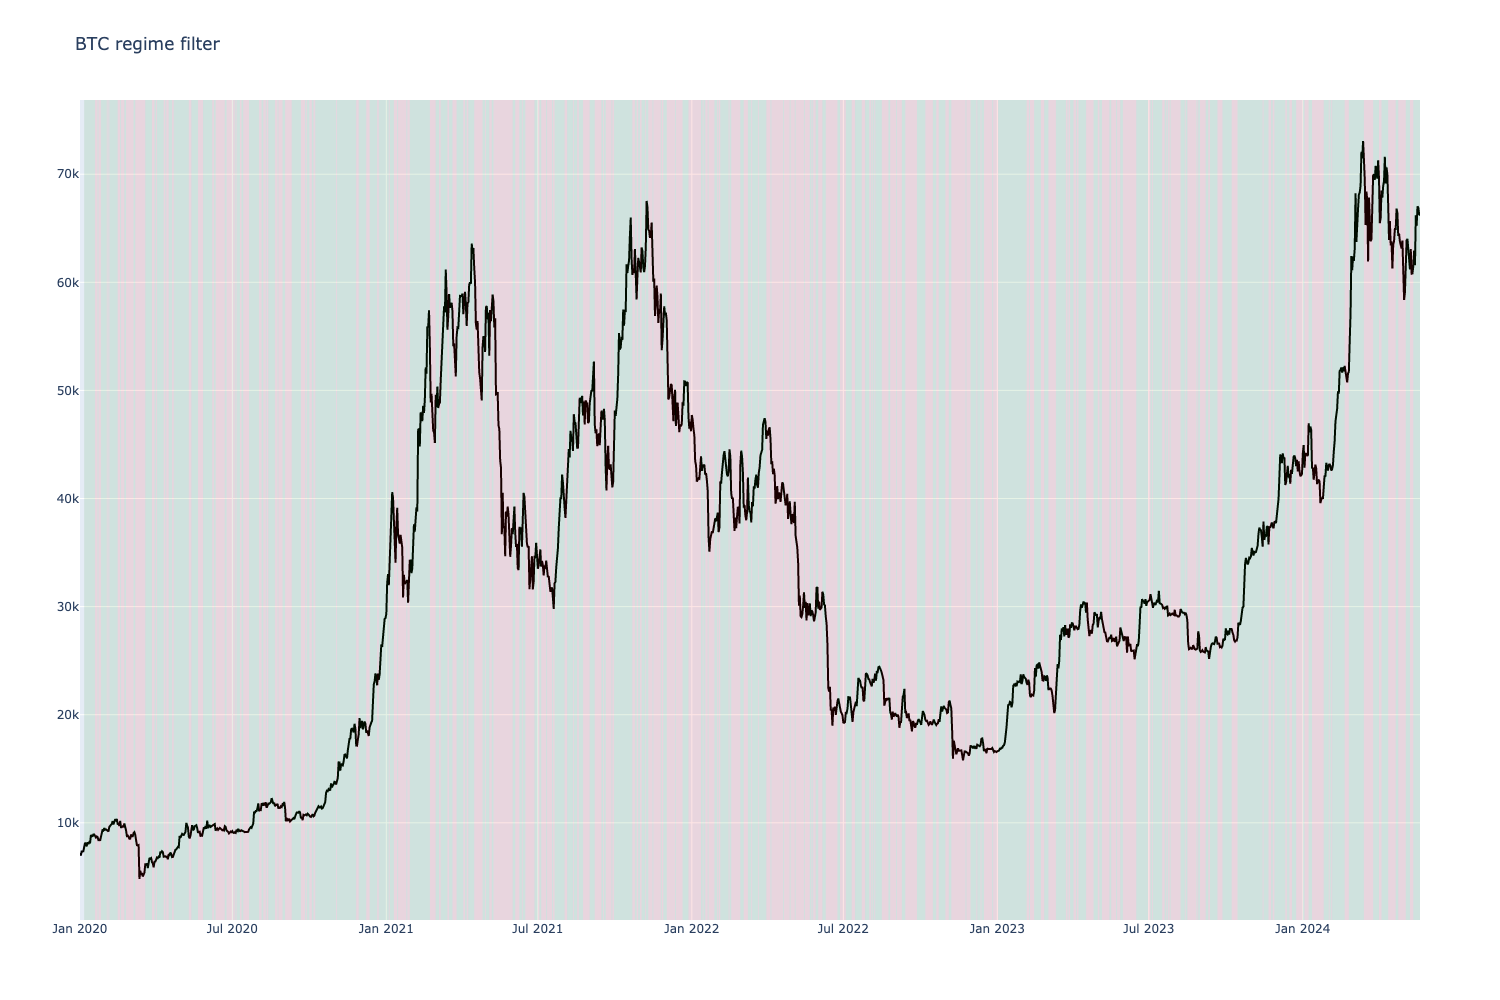

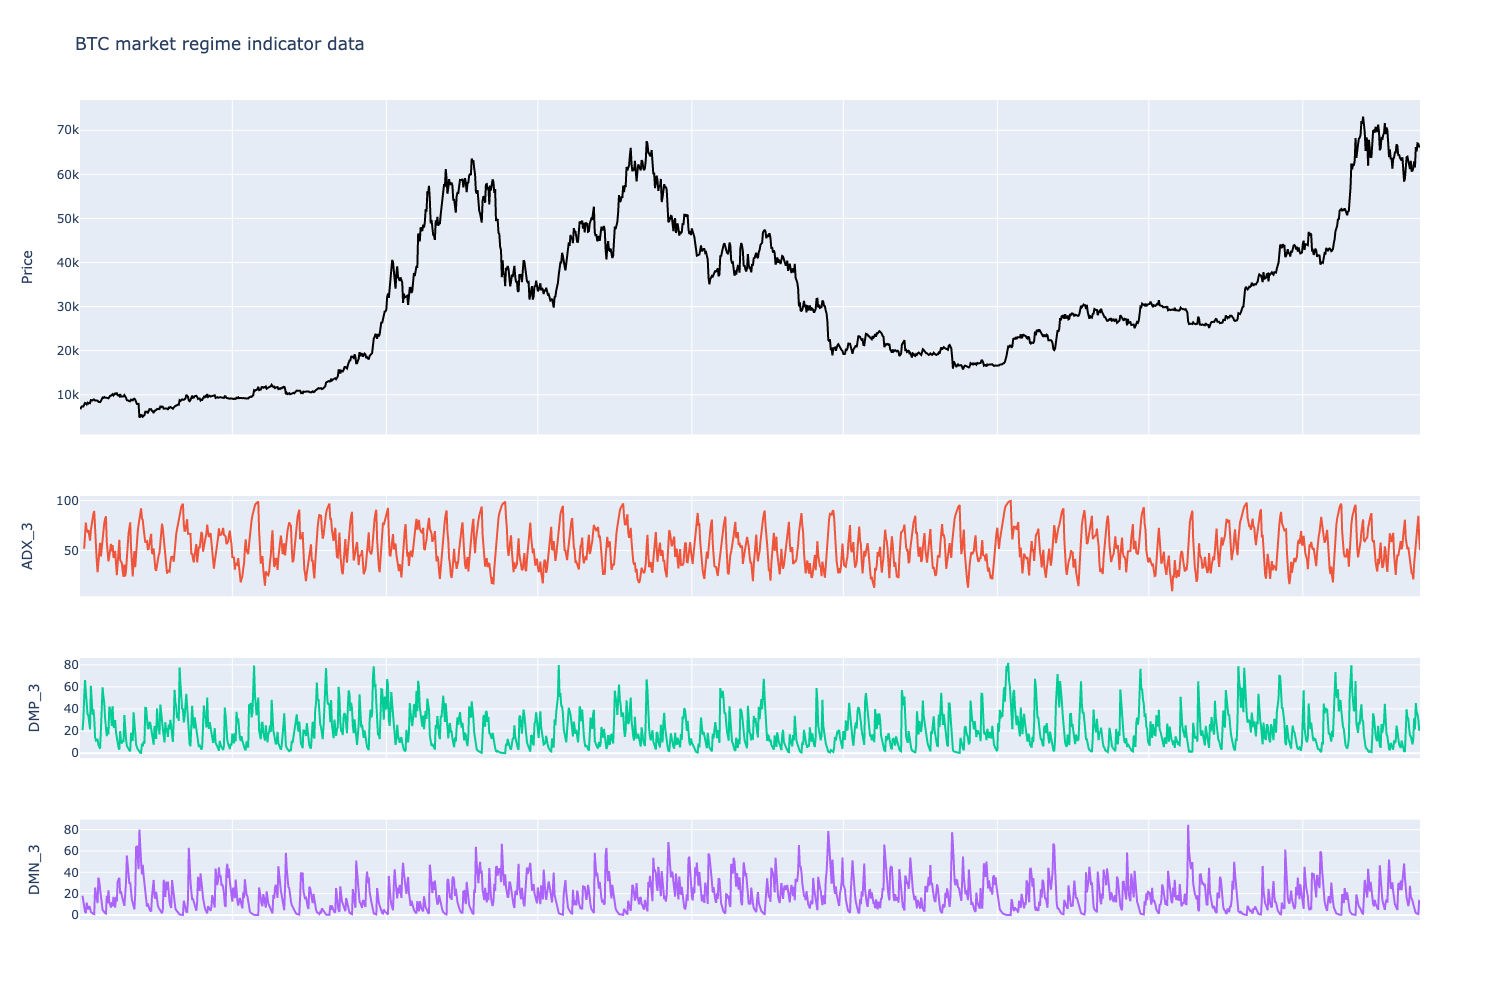

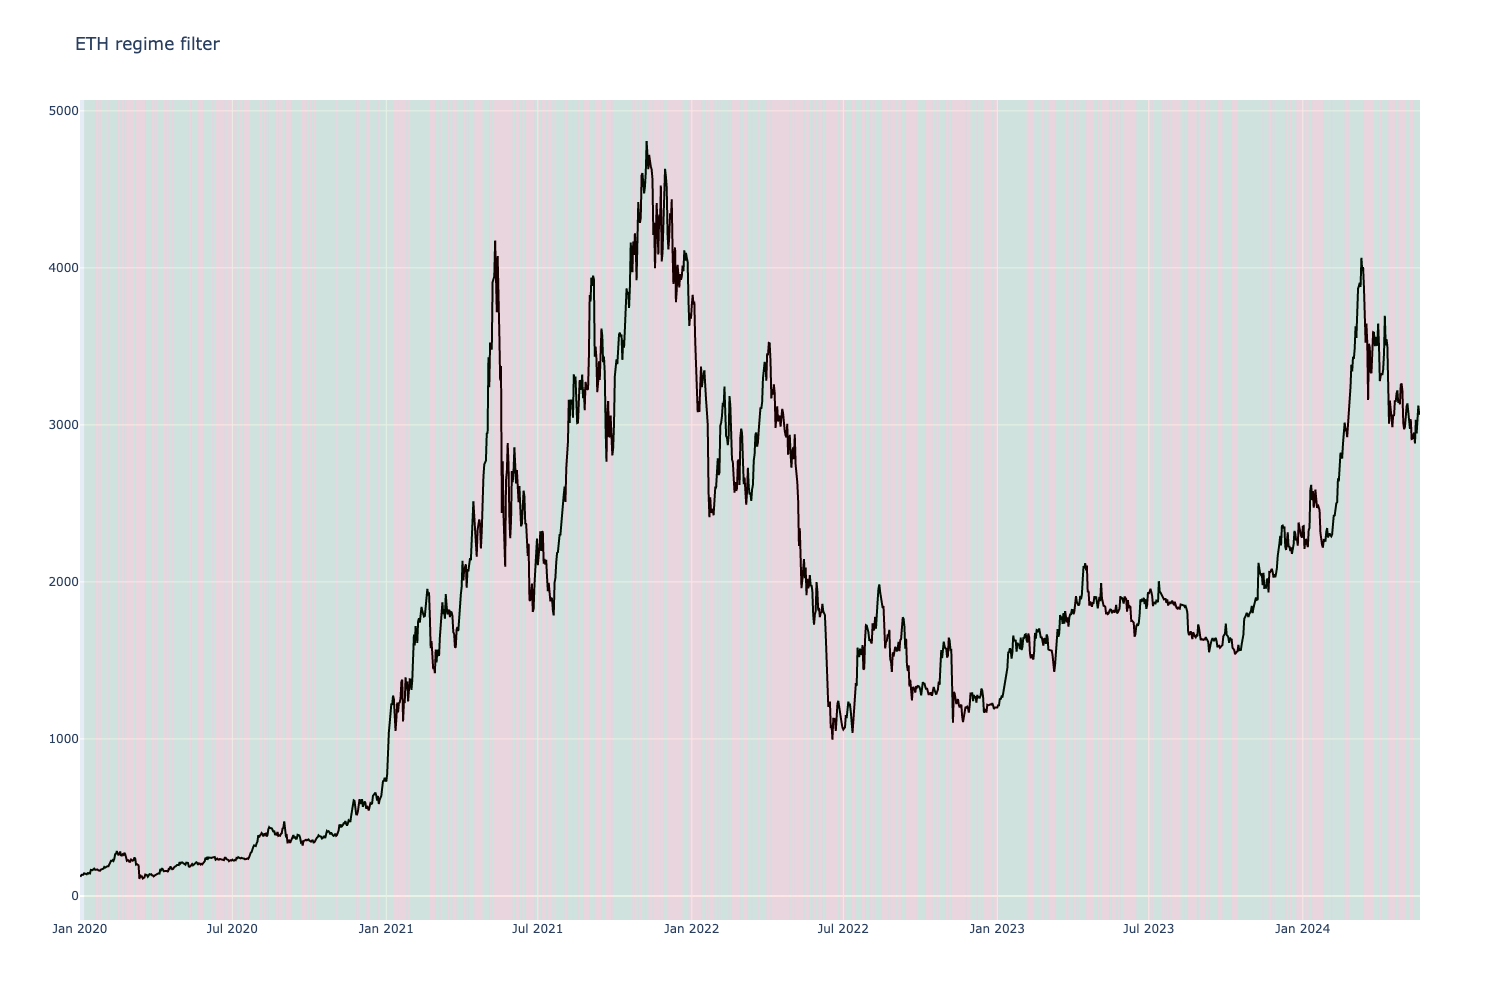

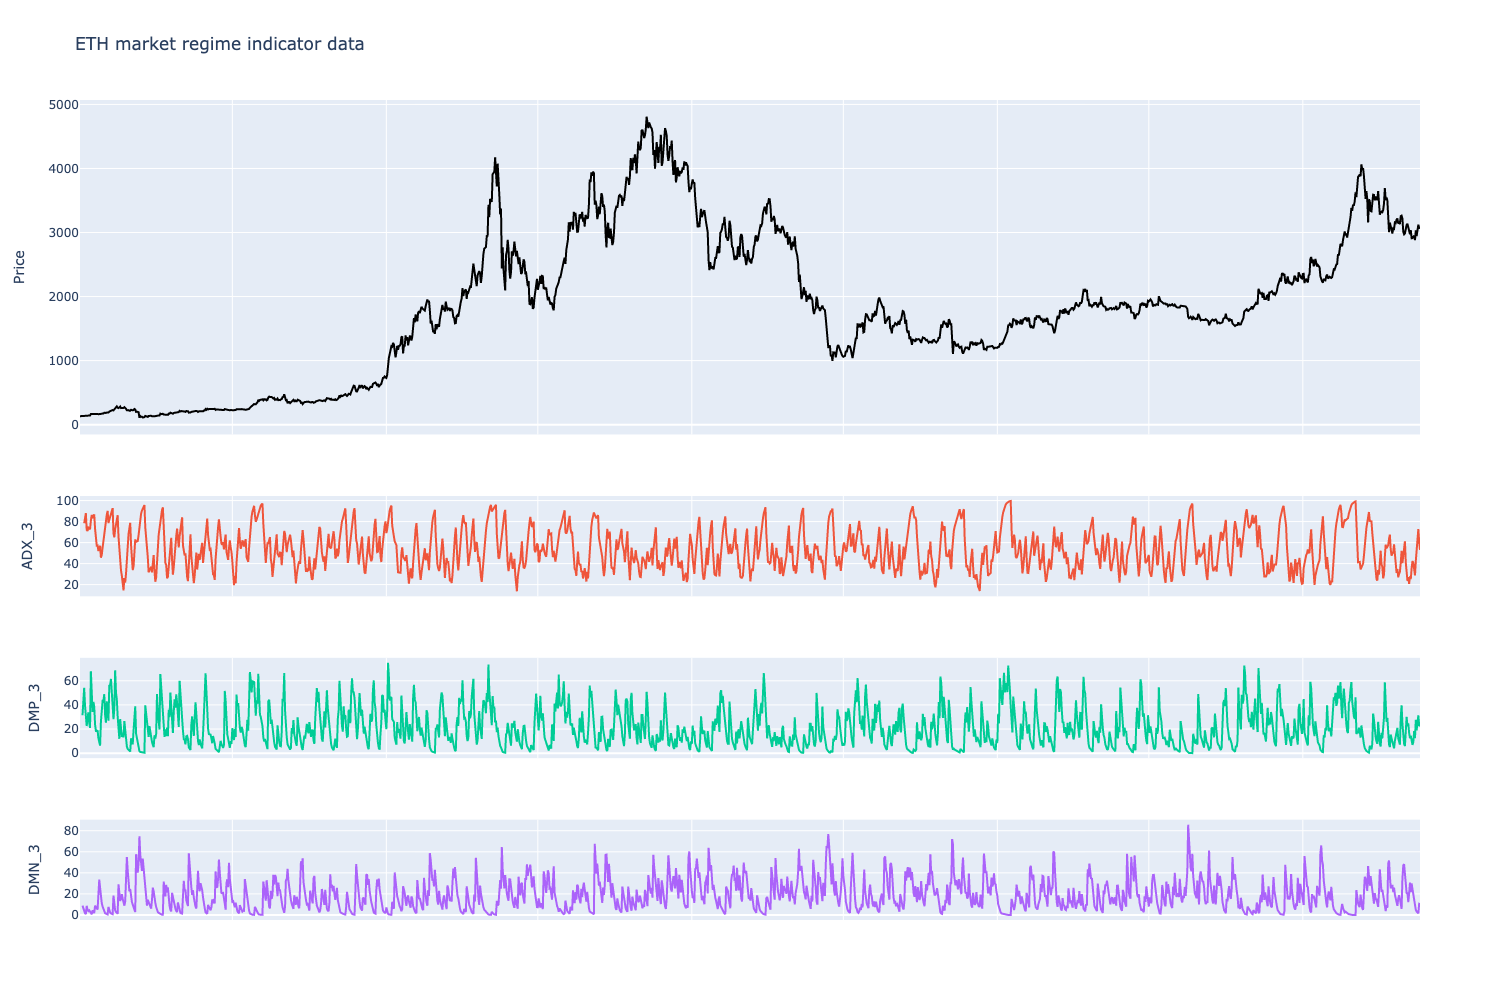

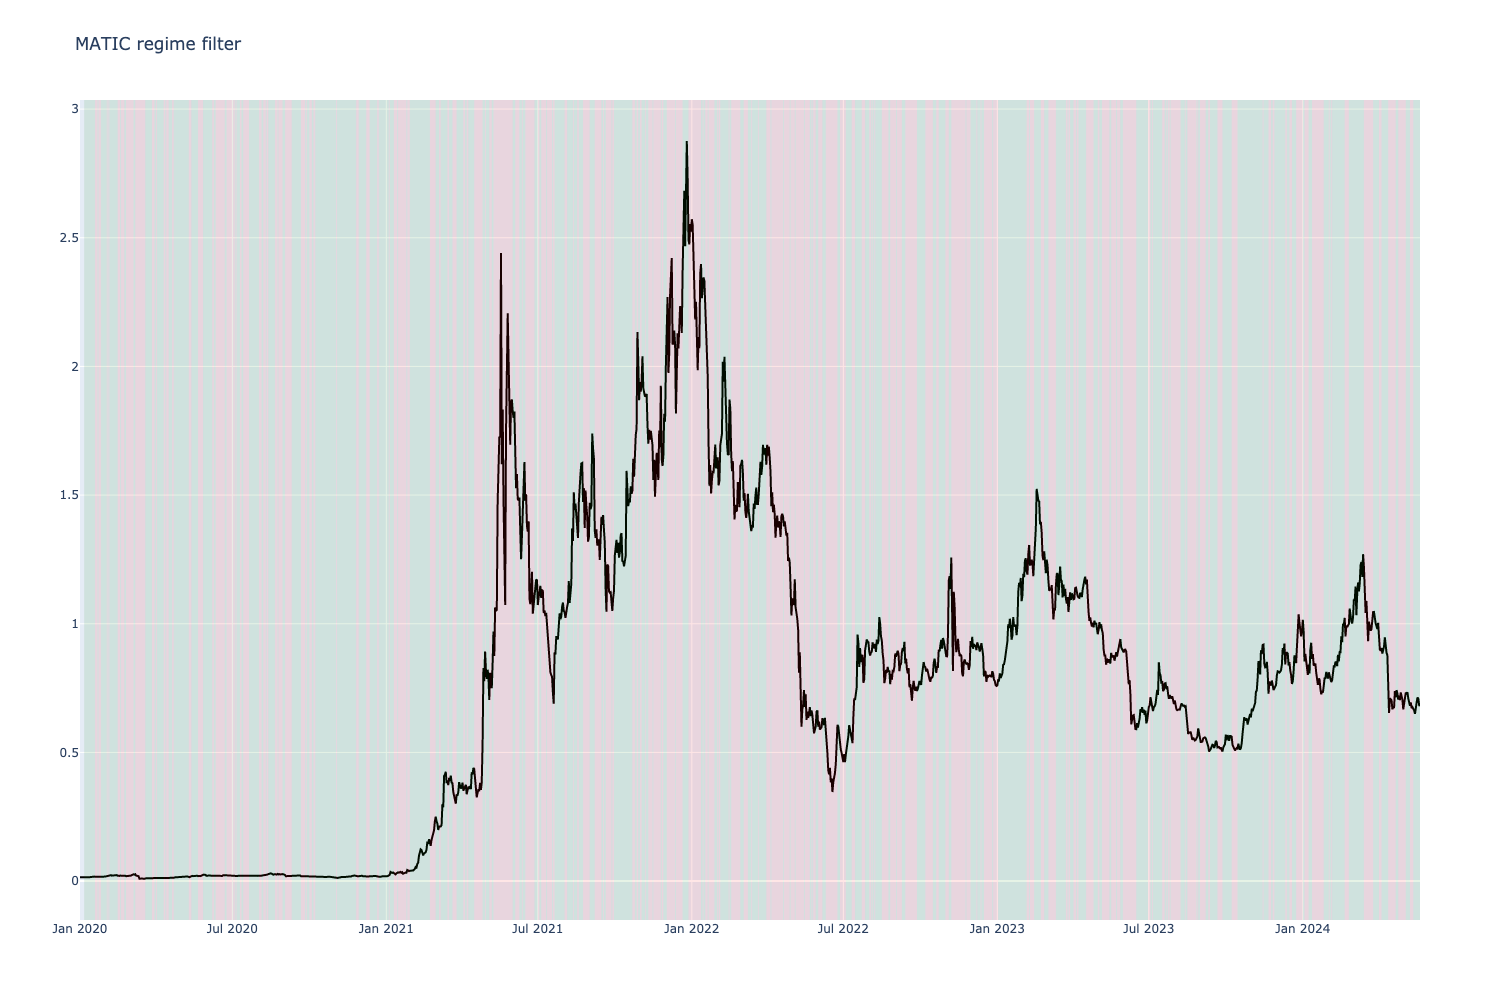

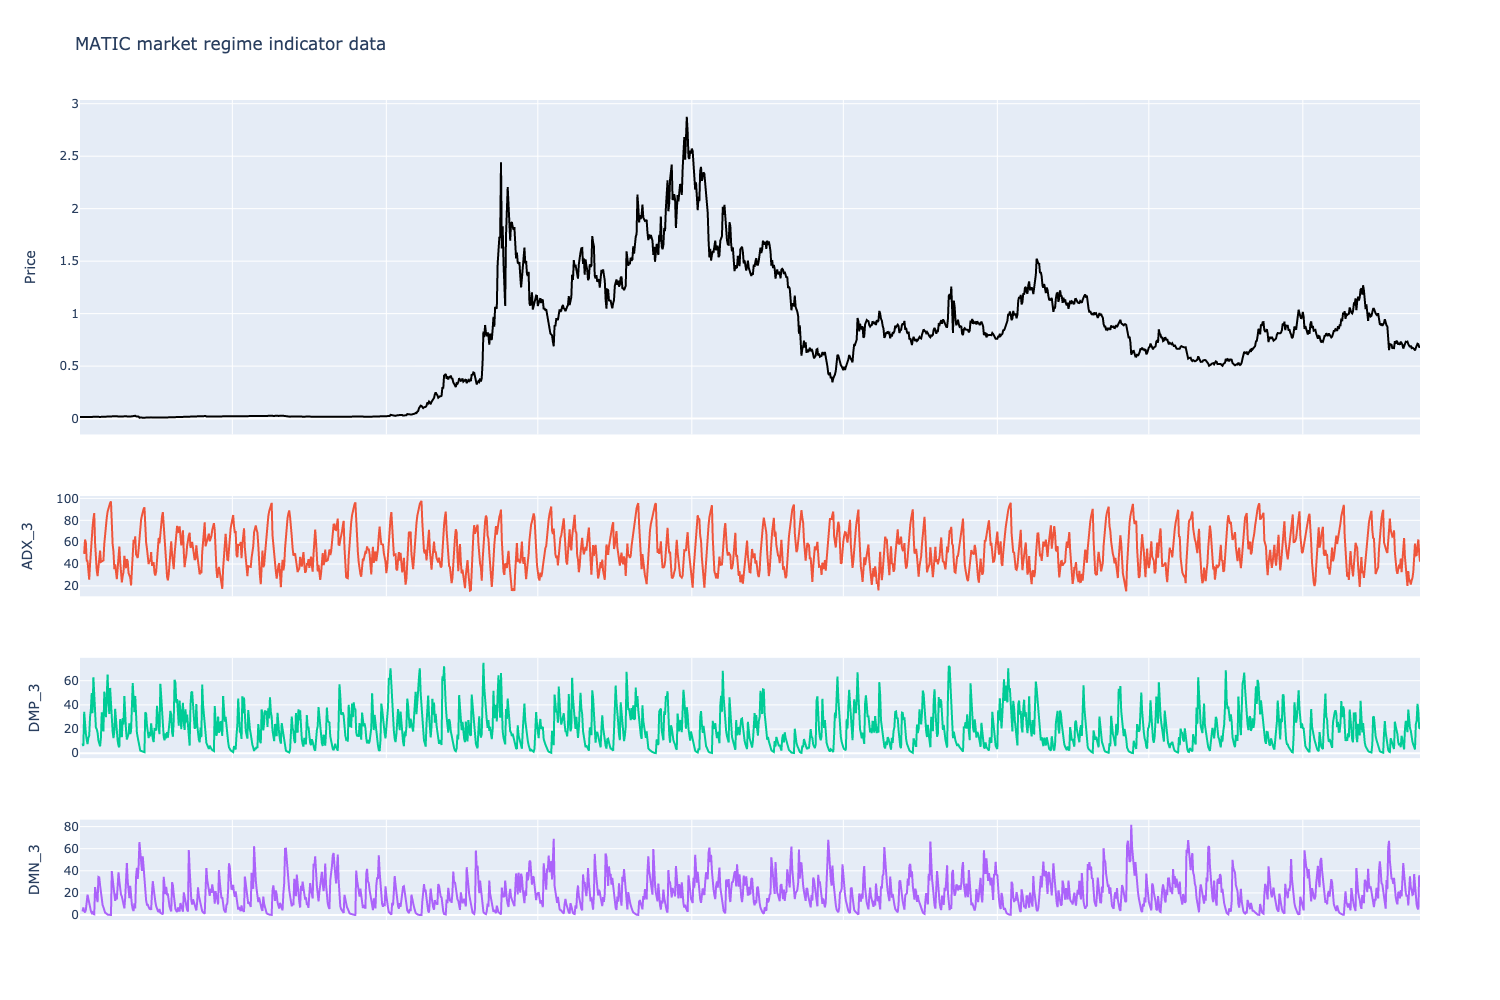

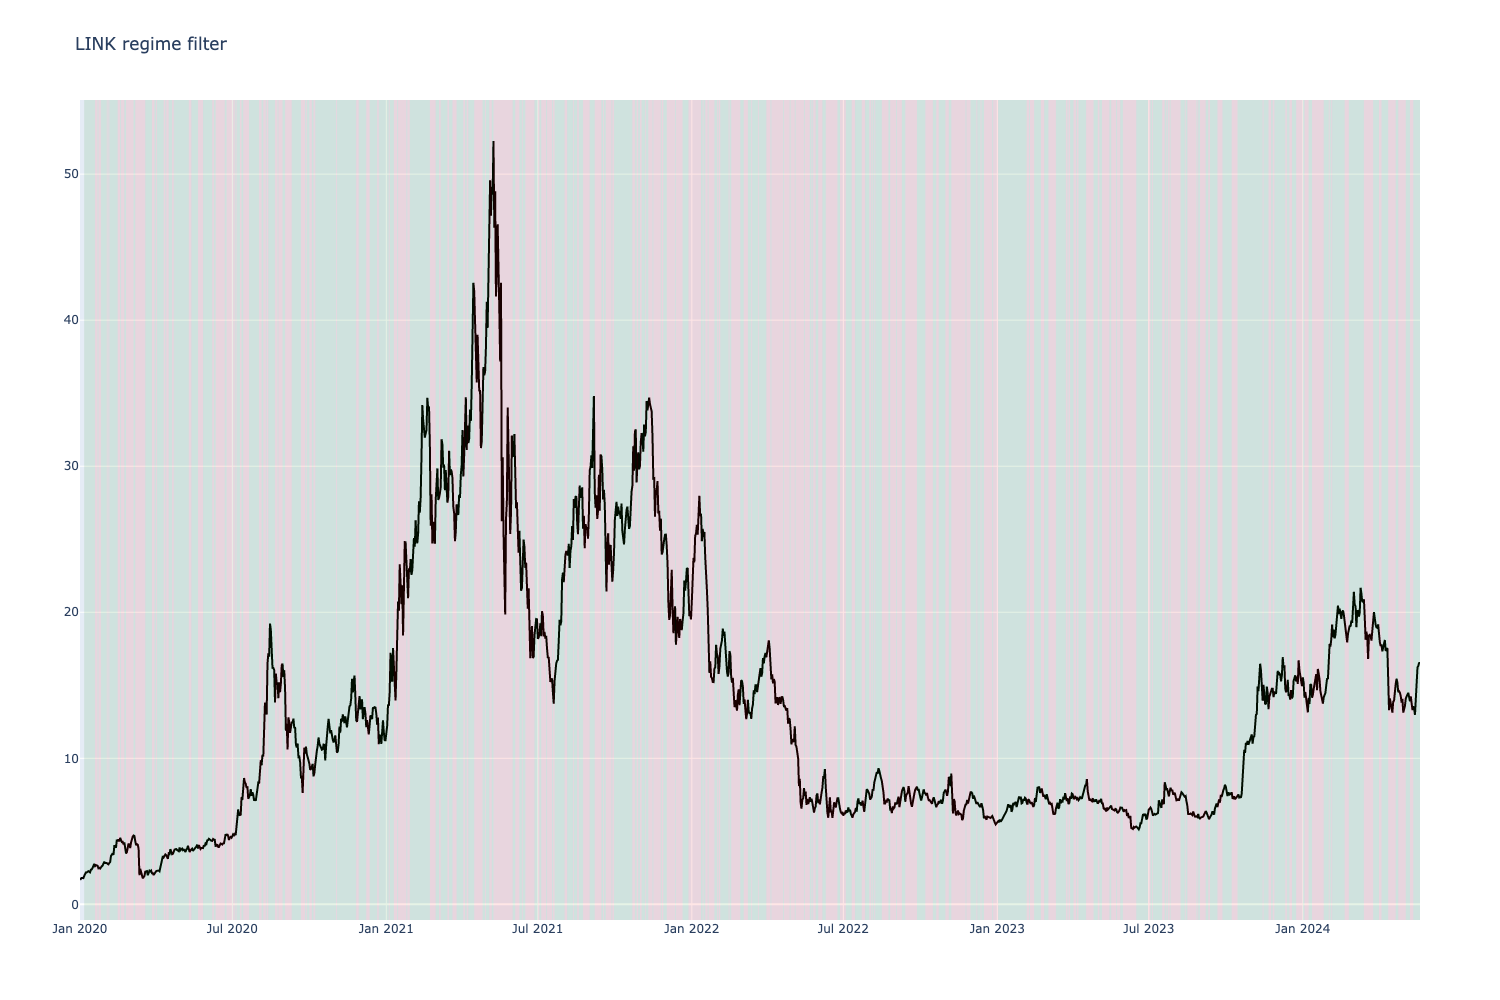

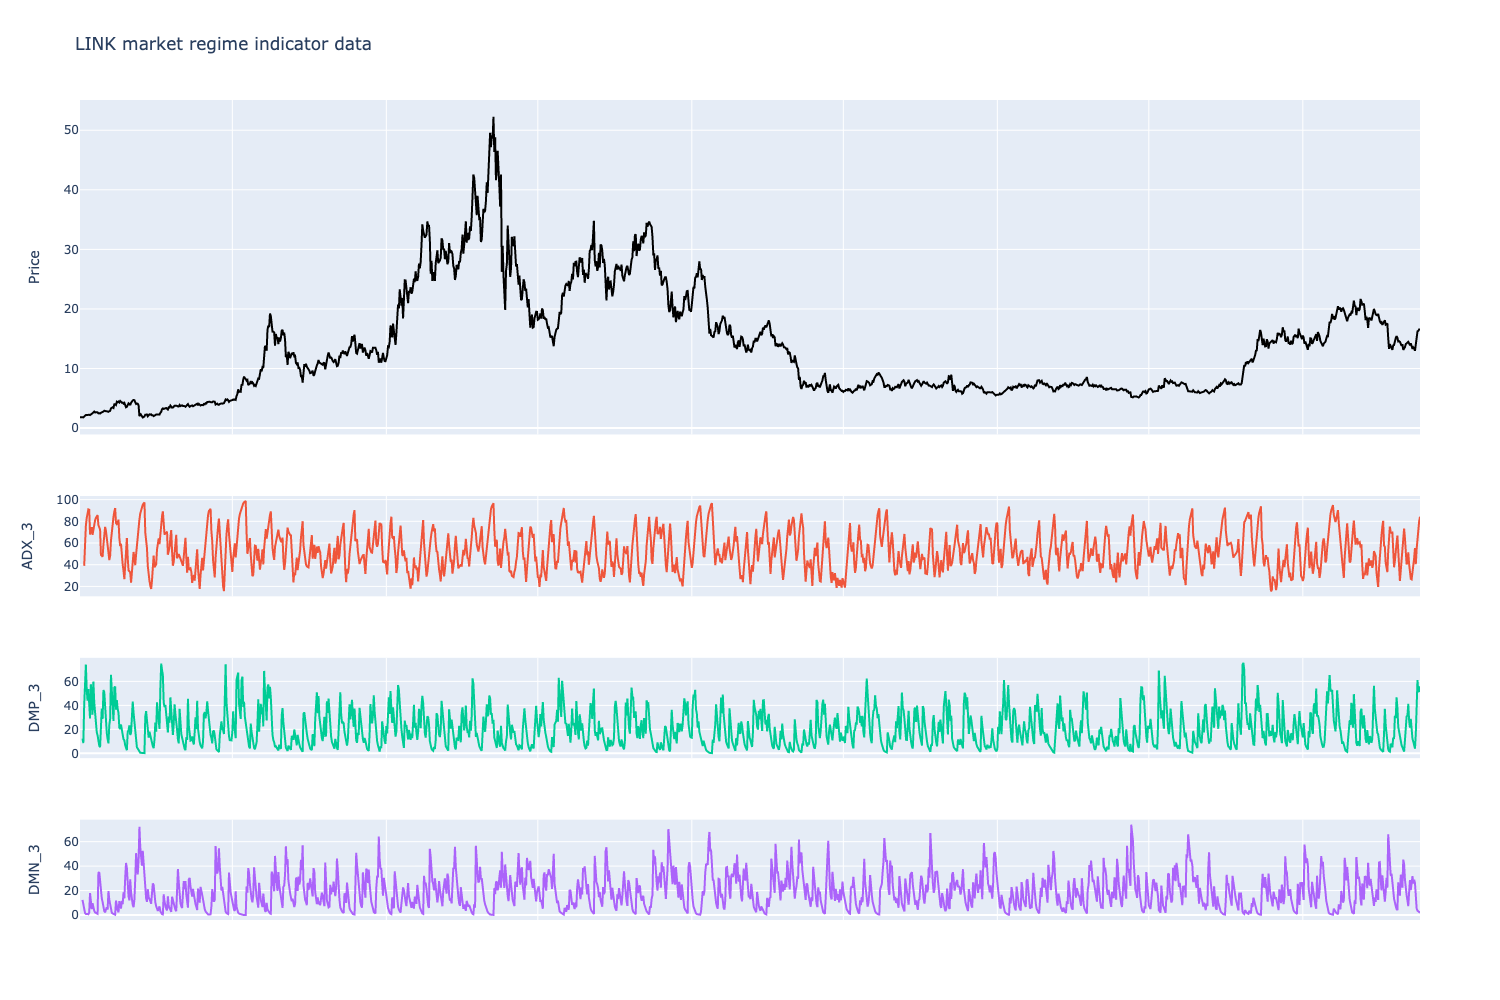

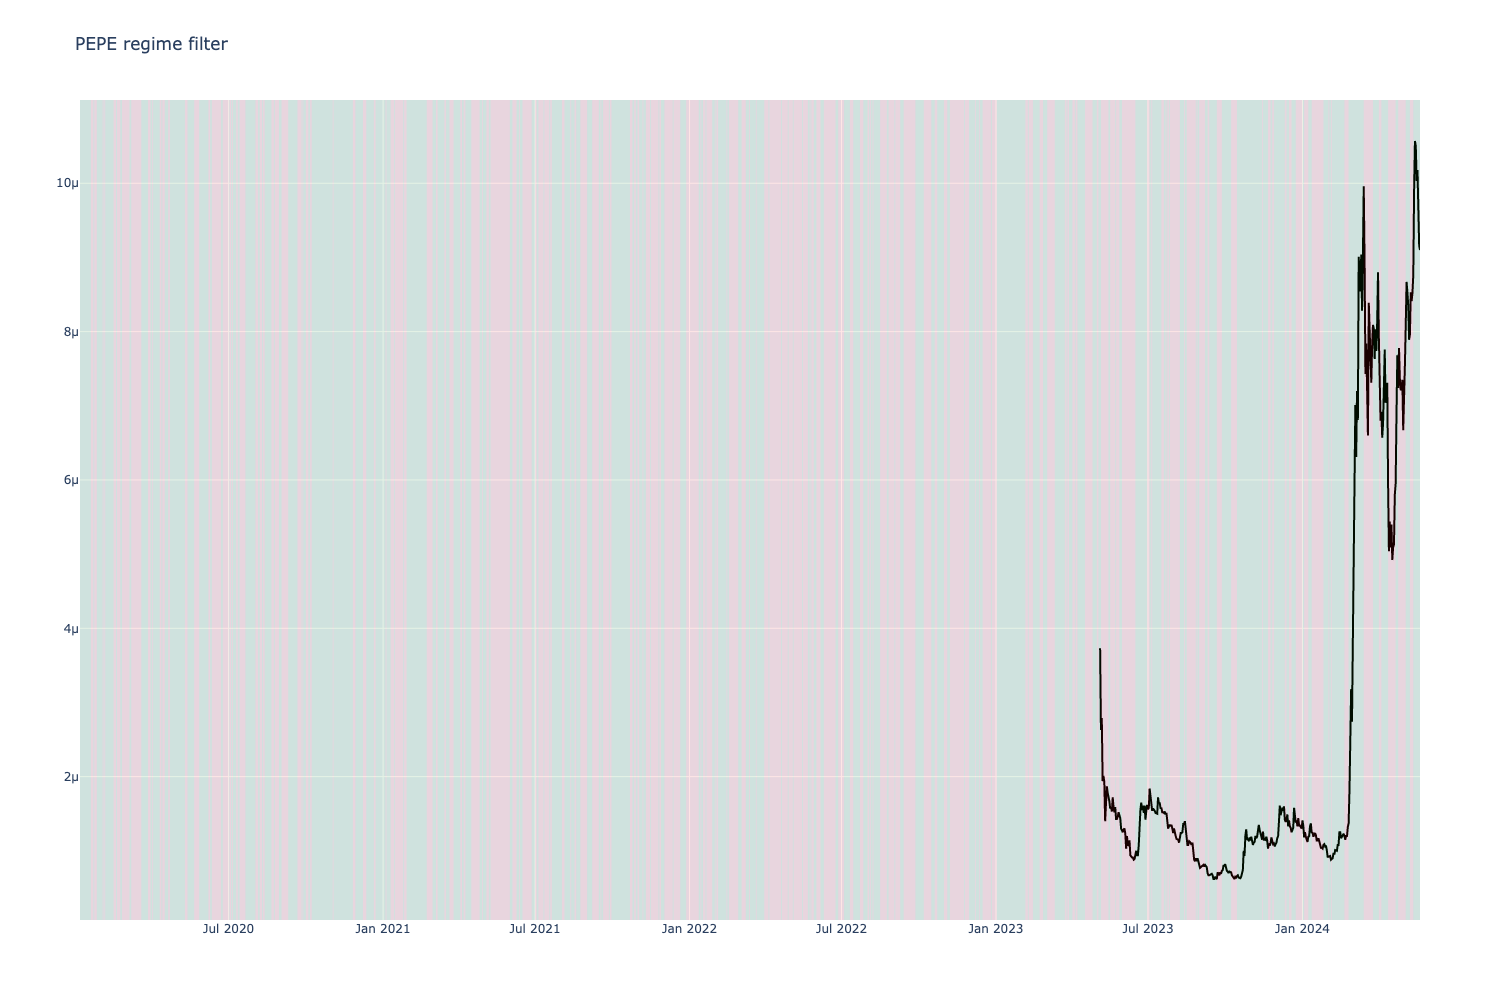

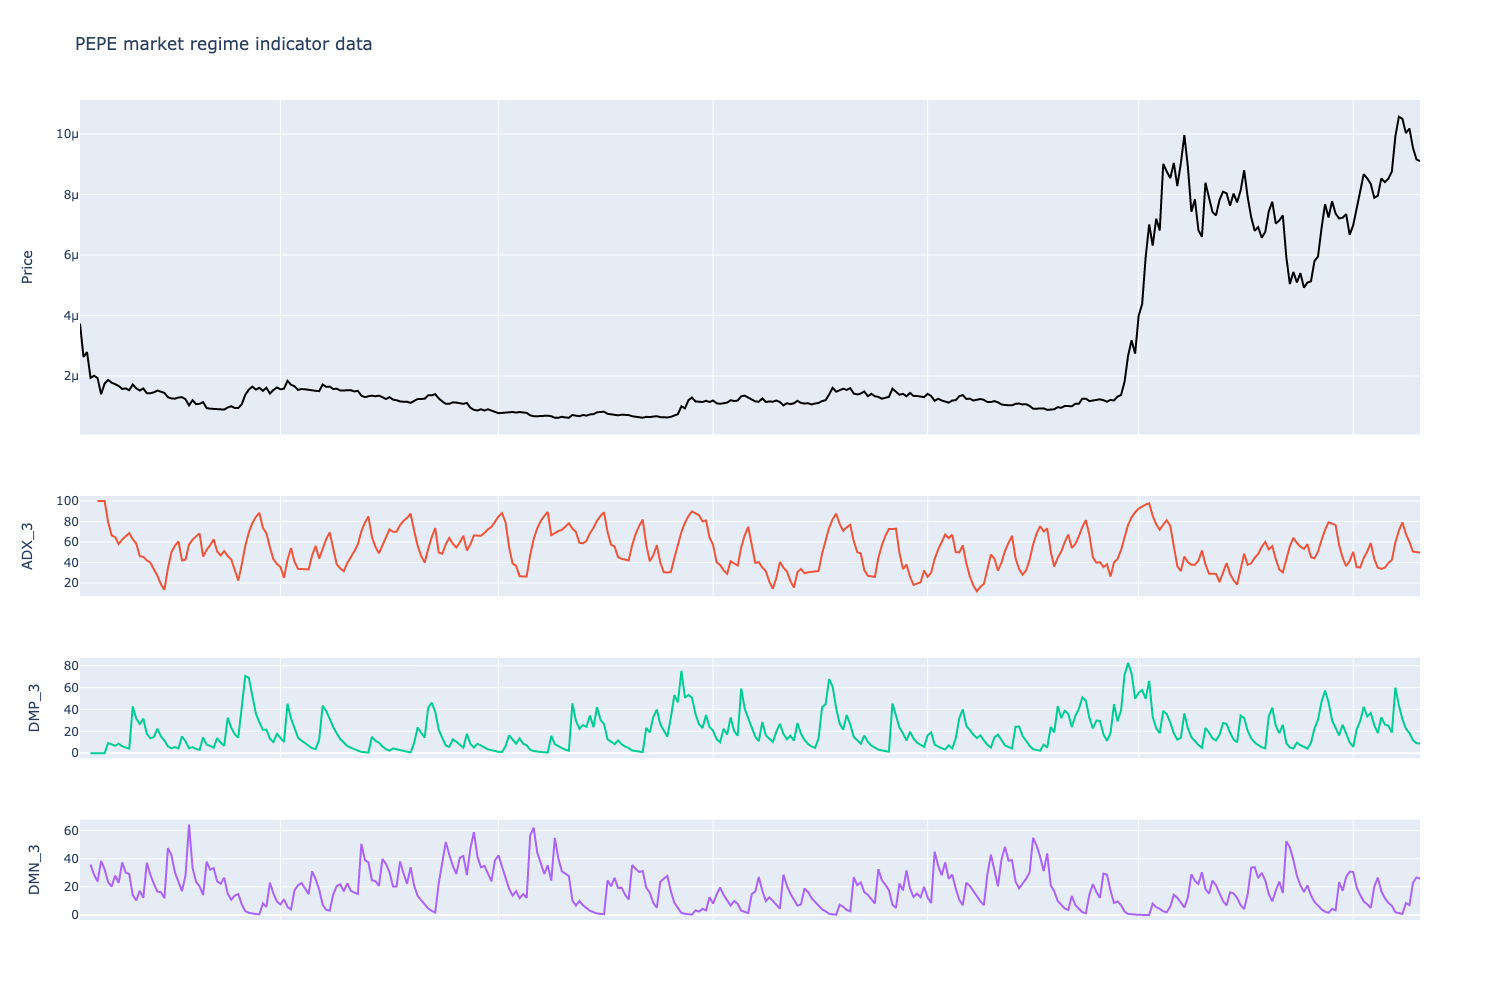

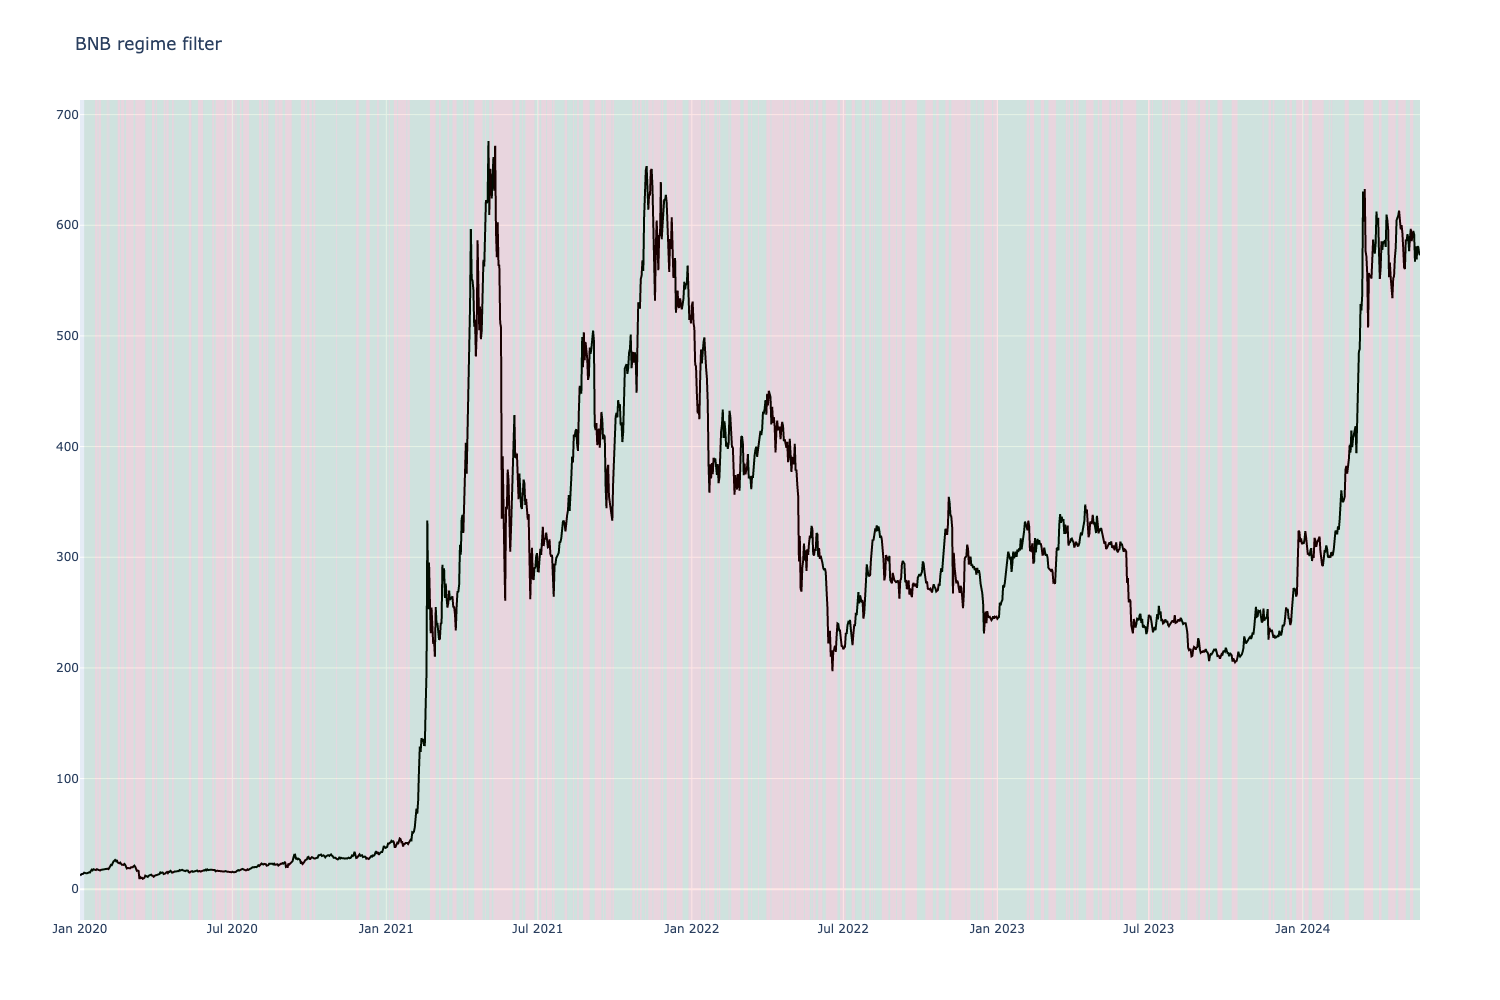

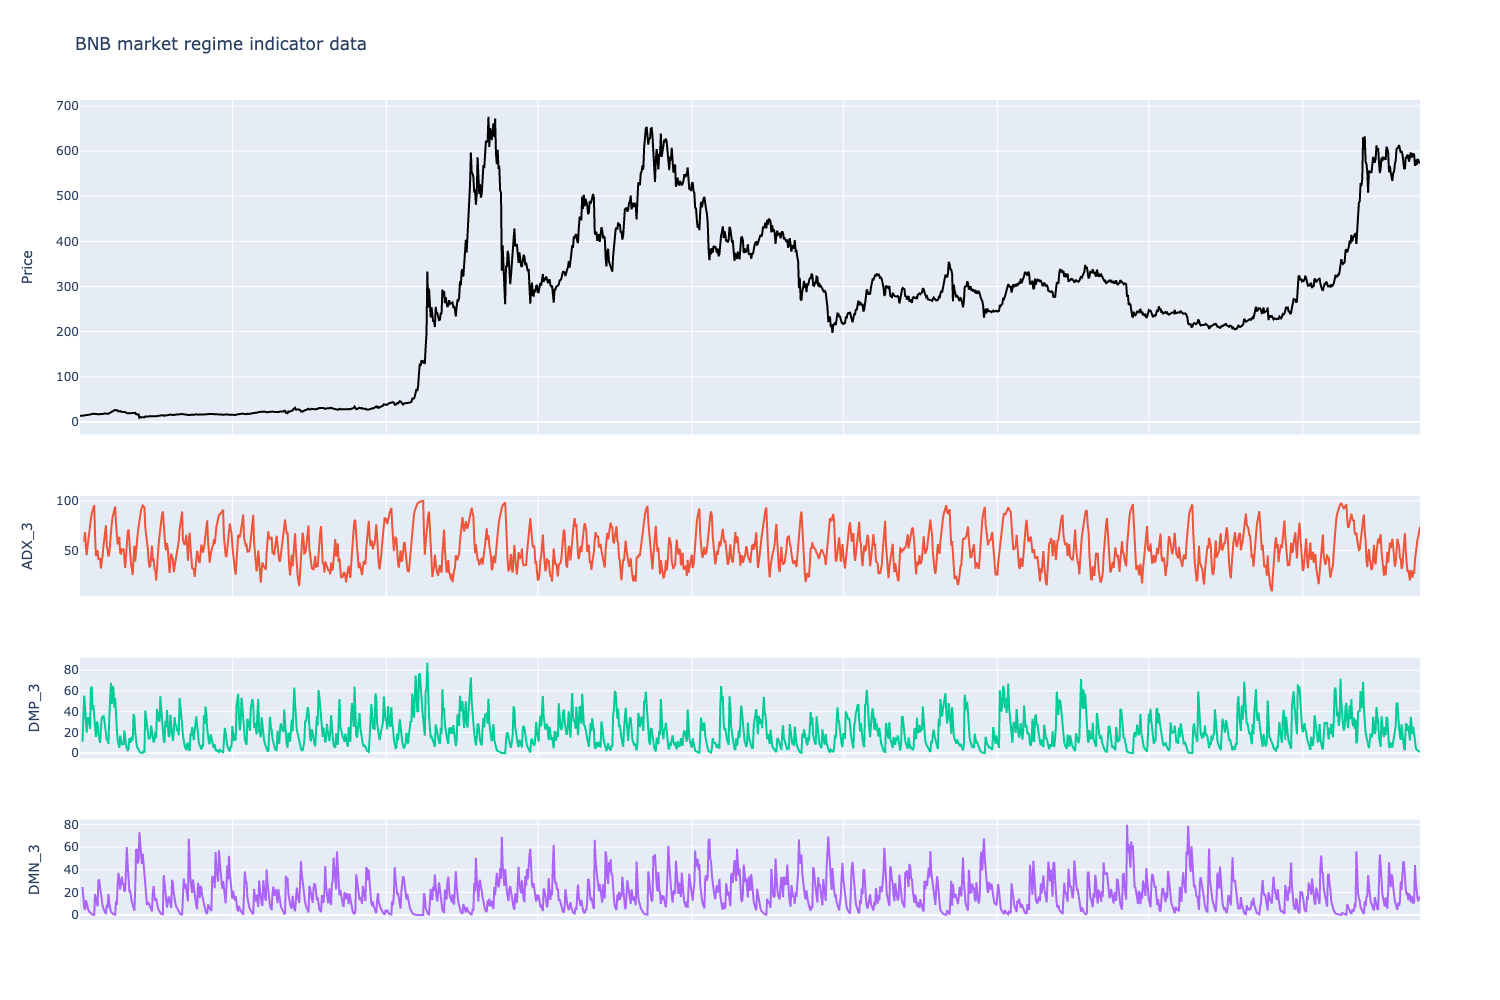

In [11]:
from tradeexecutor.visual.bullbear import visualise_market_regime_filter
from tradeexecutor.visual.bullbear import visualise_raw_market_regime_indicator

for pair_desc in trading_pairs:
    pair = strategy_universe.get_pair_by_human_description(pair_desc)

    # Pull the pair and its close price we are detecting regimes for
    daily_price = indicator_results.get_indicator_dataframe("daily_price", pair=pair)
    close_price = daily_price["close"]

    regime_signal = indicator_results.get_indicator_series("regime", pair=trading_pairs[0], unlimited=True)
    figure = visualise_market_regime_filter(
        close_price,
        regime_signal,
        title=f"{pair.base.token_symbol} regime filter"
    )
    figure.show()

    adx_df = indicator_results.get_indicator_dataframe("adx", pair=pair)
    figure = visualise_raw_market_regime_indicator(
        close_price,
        adx_df,
        height=500,
        indicator_height=150,
        title=f"{pair.base.token_symbol} market regime indicator data"
    )
    figure.show()


# Regime filter summary

- Show regime filter statistics for each trading pair
- The bullish/bearish success metric is not absolute, but ranking one: Higher is better, but the number itself is meaningless

In [12]:
data = {}

for pair_desc in trading_pairs:
    pair = strategy_universe.get_pair_by_human_description(pair_desc)

    # Pull the pair and its close price we are detecting regimes for
    daily_price = indicator_results.get_indicator_dataframe("daily_price", pair=pair)
    close = daily_price["close"]
    regime_filter = indicator_results.get_indicator_series("regime", pair=trading_pairs[0], unlimited=True)

    df = calculate_regime_filter_accuracy_df(
        close,
        regime_filter,        
    )
    summary_row = calculate_regime_match_statistics(df)
    data[pair.get_ticker()] = summary_row
    
print("Regime filter match results")
summary_df = pd.DataFrame(data).T  # Transpose
display(summary_df)



Regime filter match results


length_days  bullish_hits  bearish_hits  bullish_success  \
BTC-USDT         1602.0         250.0         250.0         0.156055   
ETH-USDT         1602.0         296.0         296.0         0.184769   
MATIC-USDT       1602.0         346.0         346.0         0.215980   
LINK-USDT        1602.0         338.0         338.0         0.210986   
PEPE-USDT         382.0          89.0          89.0         0.232984   
BNB-USDT         1602.0         273.0         273.0         0.170412   

            bearish_success  
BTC-USDT           0.337703  
ETH-USDT           0.326467  
MATIC-USDT         0.286517  
LINK-USDT          0.291511  
PEPE-USDT          0.246073  
BNB-USDT           0.326467